# Cellpose

Cellpose is a new algorithm whose goal is specifically to allow for an easy segmentation of nuclei and cell images. Just like Stardist, it mixes a conventional approach (here a diffusion based cell map) with deep learning to directly generate a label image. 

Different pre-trained models are available, some of them very versatile as they have been trained on a large variety of images. Interestingly, any model can be easily fine-tuned in the Cellpose interface and then re-used in any context, such as a notebook. You can also test the software by drag and drop on a [website](http://www.cellpose.org/).

## Loading a model

To create an instance of a model with need the sub-module ```models```:

In [4]:
from cellpose import models

Then we need to instantiate a model. The most general model is ```cyot2``` which has been trained on a large amount of data. We use it in this first example. The ```Cellpose``` model can take other arguments, in particular whether to use a GPU or not.

In [5]:
model = models.Cellpose(model_type="cyto2")

## Multi-channel

The ```cyto2``` model is special because it can consider both a signal coming from the cell and from the nuclei. It can somehow use the nuclei information to appropriately segment the cells. This is why when running inference we have to specify two channels: one for the cells and one for the nuclei. Note that **in Cellpose, channels are counted starting from 1**. For example ```channels = [2,1]``` would mean that cell signal is in channel ```2``` and the helper nuclear signal in channel ```1```. If we have a gray scale image, we can just set the channel to ```0```. Similarly, if there is no nuclear channel, we also set its value to ```0```.

## Size

Regarding size different models have different behaviors in Cellpose. The most general model ```cyto2``` contains a "sub-model" that can estimate the object size. This might slow down computations, and if we pass a value to the ```diameter``` option, it will override this behavior.

Also in general the ```diameter``` option is used to rescale the images so that the object size corresponds to that used during training.

## Practical example: only nuclei

Here we load again the image used previously with a projection of nuclei. We can try here a model specific to nuclei:

In [21]:
model_nucl = models.Cellpose(model_type="nuclei")

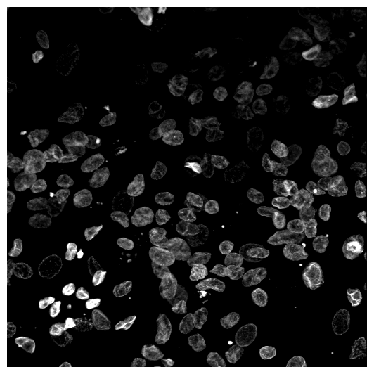

In [22]:
from aicsimageio import AICSImage
from microfilm.microplot import microshow

image = AICSImage('../data/C_Ss_3D-LR40x.czi')

image_proj = image.data[0,0,:,:,:].max(axis=0)

microshow(image_proj, limits=[0,100], fig_scaling=5);

In [27]:
import numpy as np
masks, _, _, _ = model_nucl.eval([image_proj], channels=[0,0], diameter=30)

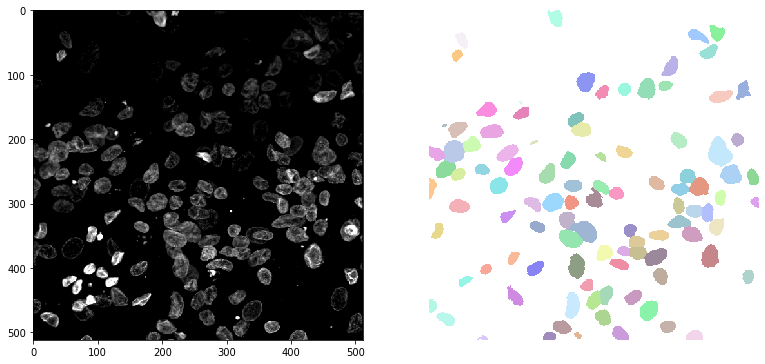

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(13,13))
microshow(image_proj, fig_scaling=5, ax=ax[0], limits=[0,100]).ax.set_axis_on()
microshow(masks, cmaps='segmentation', fig_scaling=5, ax=ax[1]);

We see a reasonable model but a few cells are still missing or badly segmented.

### Cell models on nuclei (or anything else)

The nuclei model is quite specific. If we don't have very similar data to those used for training, it might not be optimal.

Instead we can use one of the very general cell models. As those have been trained on many images with very different features, these models are very good at picking up anything that looks like a "bloby" object. So now we load and use the ```cyto2``` model but on nuclei!

In [29]:
model_cell = models.Cellpose(model_type="cyto2")

In [30]:
masks, _, _, _ = model_cell.eval([image_proj], channels=[0,0], diameter=30)

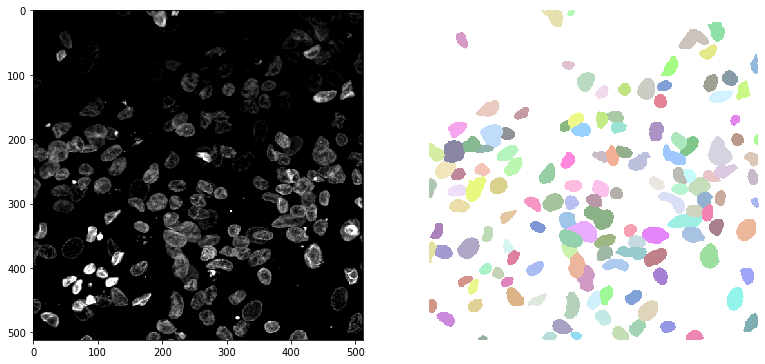

In [31]:
fig, ax = plt.subplots(1,2, figsize=(13,13))
microshow(image_proj, fig_scaling=5, ax=ax[0], limits=[0,100]).ax.set_axis_on()
microshow(masks, cmaps='segmentation', fig_scaling=5, ax=ax[1]);

This is much better than expected!

## Combined cell and nuclei model

Now we can test this model on an image that actually contains cellular and nuclear signals. We load again an image from the cell atlas:

In [33]:
import skimage

image = skimage.io.imread('../data/cellaltlas/19838_1252_F8_1.tiff')

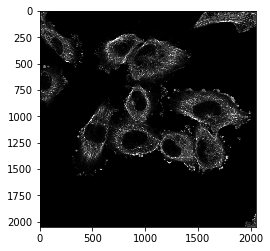

In [49]:
microshow(np.moveaxis(image, 2, 0)[0,:,:]).ax.set_axis_on()

The cells have a size of ~500 pixels and the cytoplasmic signal is the first channel, while the nuclear signal is the third one:

In [57]:
masks, _, _, _ = model_cell.eval([image], channels=[2,0], diameter=300)

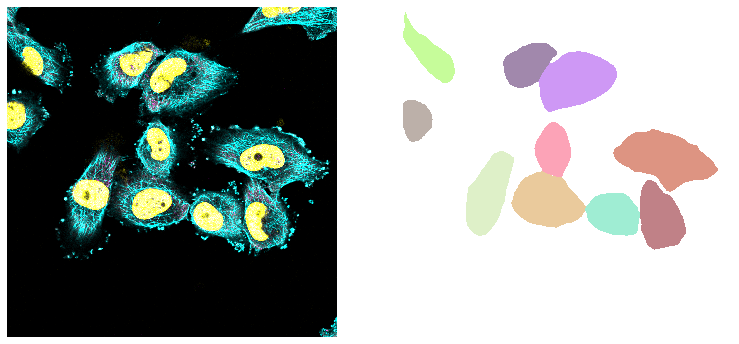

In [58]:
fig, ax = plt.subplots(1,2, figsize=(13,13))
microshow(np.moveaxis(image, 2, 0), fig_scaling=5, ax=ax[0], limits=[0,100])
microshow(masks, cmaps='segmentation', fig_scaling=5, ax=ax[1]);

## Application to other cases

Some of the models are so general, that they can be used out of the box on conpletely different imaged. For exqme

In [59]:
stones = skimage.io.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Moelen.jpg/1024px-Moelen.jpg')

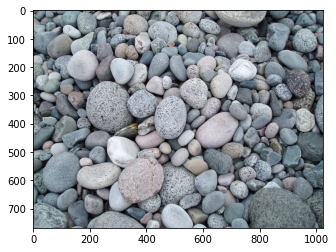

In [60]:
plt.imshow(stones);

Let's first convert this image to gray:

In [63]:
stones_gray = skimage.color.rgb2gray(stones)

In [72]:
masks, _, _, _ = model_cell.eval([stones_gray], channels=[0,0], diameter=100)

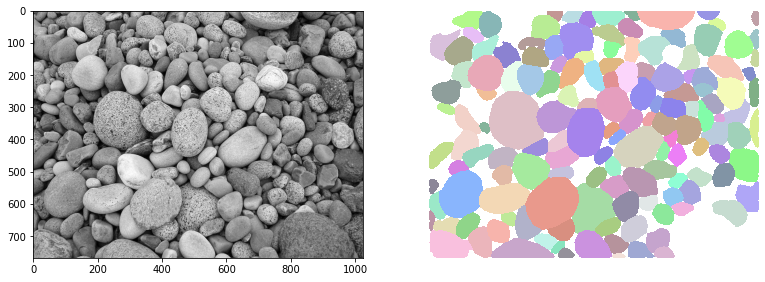

In [73]:
fig, ax = plt.subplots(1,2, figsize=(13,13))
ax[0].imshow(stones_gray, cmap='gray')
microshow(masks, cmaps='segmentation', fig_scaling=5, ax=ax[1]);

## Exercise

Import the image ```OC-FOV_ARHGAP21_ENSG00000107863_CID000556_FID00024477_stack.tiff``` and keep ony the plane 50. Try to segment the cells (channel 2) using the nuclei as help with the ```cyto2``` model of Cellpose.